In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import tensorflow as tf
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from timeit import default_timer as timer

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


In [2]:
df = pd.read_csv("../Iris.csv")
df.replace(to_replace="Iris-setosa", value=0, inplace=True)
df.replace("Iris-versicolor", 1, inplace=True)
df.replace("Iris-virginica", 2, inplace=True)
df.head()



/var/folders/8_/t3znlm6s3n1gdhfwvmxv3gp40000gn/T/ipykernel_38286/1182936694.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("Iris-virginica", 2, inplace=True)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [3]:
X = df[df.columns[:len(df.columns)-1]]
y = df["Species"]

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(np.array(X))
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


In [4]:
f1 = []
log_loss = []  
accuracy = []
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(x_test)
    index = []
    for array in y_pred:
        for i in range(len(array)):
            if max(array, key=lambda x: x) == array[i]:
                index.append(i)

    # Evaluate the model on training and testing data
    f1.append(metrics.f1_score(y_test, index , average='micro'))
    log_loss.append((metrics.log_loss(y_test, y_pred)))
    accuracy.append(metrics.balanced_accuracy_score(y_test, index))

In [5]:
class Model_Timer(tf.keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [6]:
model = Sequential([
    (SimpleRNN(50,return_sequences=True)),
    (SimpleRNN(50,return_sequences=True)),
    (SimpleRNN(50,return_sequences=True)),
    (SimpleRNN(50)),
    Dense(3, activation="softmax")
])
cb = Model_Timer()
# Compile the model
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy", "MeanAbsoluteError","RootMeanSquaredError", "MeanSquaredError"])
model.fit(x_train, y_train, batch_size=8, epochs=25, validation_data=(x_test, y_test),callbacks=[PredictionCallback(), cb])

Epoch 1/25
15/15 [==============================] - 1s 35ms/step - loss: 0.9203 - accuracy: 0.4333 - mean_absolute_error: 0.9083 - root_mean_squared_error: 1.0895 - mean_squared_error: 1.1870 - val_loss: 0.5518 - val_accuracy: 0.7667 - val_mean_absolute_error: 0.8111 - val_root_mean_squared_error: 1.0065 - val_mean_squared_error: 1.0130
Epoch 2/25
15/15 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.8667 - mean_absolute_error: 0.9083 - root_mean_squared_error: 1.1107 - mean_squared_error: 1.2336 - val_loss: 0.3605 - val_accuracy: 0.8333 - val_mean_absolute_error: 0.8111 - val_root_mean_squared_error: 1.0248 - val_mean_squared_error: 1.0503
Epoch 3/25
15/15 [==============================] - 0s 4ms/step - loss: 0.3475 - accuracy: 0.8917 - mean_absolute_error: 0.9083 - root_mean_squared_error: 1.1224 - mean_squared_error: 1.2597 - val_loss: 0.2649 - val_accuracy: 0.9333 - val_mean_absolute_error: 0.8111 - val_root_mean_squared_error: 1.0346 - val_mean_squared

In [7]:
time_took_to_run = sum(cb.logs)
time_took_to_run

2.8415416702628136

In [8]:
# Predict using the trained model
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

1/1 [==============================] - 0s 9ms/step


In [9]:
index = []
for array in test_predictions:
    for i in range(len(array)):
        if max(array, key=lambda x: x) == array[i]:
            index.append(i)

# Evaluate the model on training and testing data
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, index))
print("Accuracy (balanced): " + str(metrics.accuracy_score(y_test, index)))
print(f"F1 Score: {metrics.f1_score(y_test, index , average='micro')}")
print(f"Log Loss: {metrics.log_loss(y_test, test_predictions)}")
print(f"Confusion Matrix: {metrics.multilabel_confusion_matrix(y_test, index)}")
print(max(accuracy)-min(accuracy))

Accuracy (balanced): 1.0
F1 Score: 1.0
Log Loss: 0.01974530315794838
Confusion Matrix: [[[19  0]
  [ 0 11]]

 [[19  0]
  [ 0 11]]

 [[22  0]
  [ 0  8]]]
0.21212121212121204


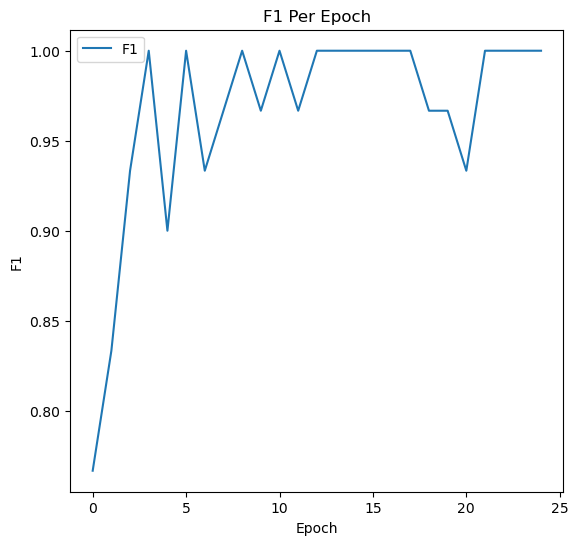

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(f1, label="F1")
plt.title('F1 Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

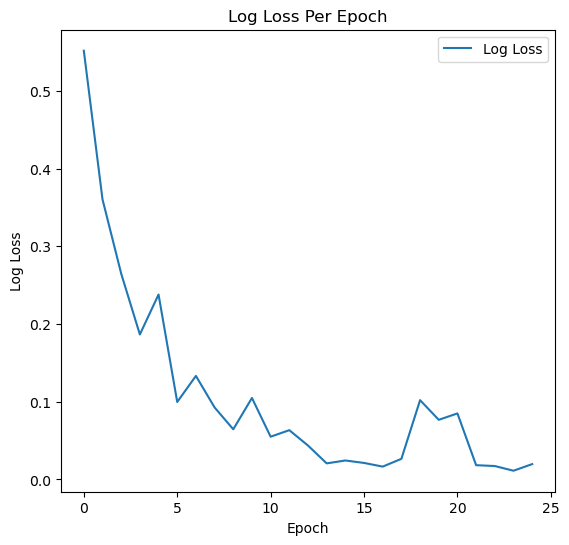

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(log_loss, label="Log Loss")
plt.title('Log Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

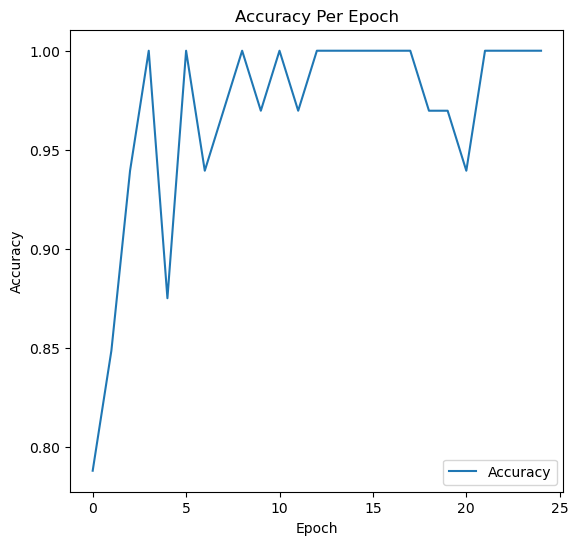

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label="Accuracy")
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

[[11  0  0]
 [ 0 11  0]
 [ 0  0  8]]


<Axes: >

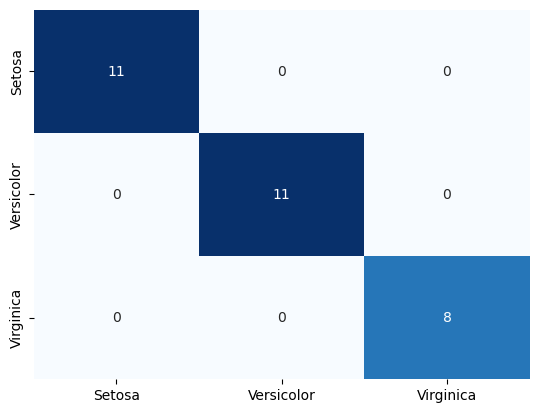

In [13]:
cm = metrics.confusion_matrix(y_test, index)
print(cm)
sns.heatmap(cm, cmap="Blues", cbar=False, annot=True, fmt='d', xticklabels=["Setosa", "Versicolor", "Virginica"], yticklabels=["Setosa", "Versicolor", "Virginica"])